<a href="https://colab.research.google.com/github/naenumtou/ifrs9/blob/main/PD/transitionMatrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Change directory to Google Drive
%cd /content/drive/My Drive/Colab Notebooks/survivalAnalysisPD

/content/drive/My Drive/Colab Notebooks/survivalAnalysisPD


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

In [3]:
# Import data
transaction = pd.read_parquet('transaction.parquet',
                              engine = 'pyarrow')

print(f'Total rows: {transaction.shape[0]}')
print(f'Total columns: {transaction.shape[1]}')

Total rows: 12244923
Total columns: 7


In [4]:
# Flag inactive (closed) and write-off account
condition = ((transaction['Status'].eq(0)) |
             (transaction['writeOff'].eq(1)))
transaction['Aging'] = np.where(condition, -1, transaction['Aging']) #Assign -1 for closed (not same as mask)

In [5]:
# Create 12-Months forward performance window
transaction = transaction.sort_values(by = ['AccID', 'Monthkey']) #Sort data by month
maxMonthkey = transaction['Monthkey'].max() #Find maximum monthkey
lag = 12 #12-Months performance window

# 12-Months observed
for i in range(1, lag + 1): #+1 to include month at 12
  transaction[f'Aging{i}'] = transaction.groupby(['AccID'])['Aging'].shift(-i).astype(np.float16)
  print(f'Column: {transaction.columns[-1]} created')

Column: Aging1 created
Column: Aging2 created
Column: Aging3 created
Column: Aging4 created
Column: Aging5 created
Column: Aging6 created
Column: Aging7 created
Column: Aging8 created
Column: Aging9 created
Column: Aging10 created
Column: Aging11 created
Column: Aging12 created


In [6]:
# Create 12-Months status
transaction['12MStatus'] = transaction.loc[:, 'Aging1':'Aging12'].max(axis = 1)

In [7]:
# Fill with the last status for performing loan
# df.mask(df.eq(-1)).ffill(axis = 1) --> slow
# Using dictionary structure and map for speed

# Find last status on each account
lastStatus = transaction.groupby(['AccID'], as_index = False).tail(1)
lastStatus = lastStatus.set_index('AccID')['Aging'].to_dict() #Set 'AccID' to index as primary key and convert to dictionary

In [8]:
# Exclusion rules
# 1: Selecte only active account
# 2: Exclude less than 12-months performance window
transaction = transaction.query('Status == 10 & Monthkey <= @maxMonthkey - 12')

# 3: Exclude no next month performance
transaction = transaction[transaction['Aging1'].notnull()]

In [9]:
# Fix '12MStatus' to 'Aging12' status for performing loan
condition = transaction['12MStatus'] != 4
transaction['12MStatus'] = np.where(condition, transaction['Aging12'], transaction['12MStatus'])

In [10]:
# Mapping only missing row only active loan (for performing loan)
condition = ((transaction['Aging12'].isnull()) & 
             (transaction['12MStatus'] != 4))
transaction['12MStatus'] = np.where(condition,
                                    transaction['AccID'].map(lastStatus),
                                    transaction['12MStatus'])

In [11]:
# 12-Month status flag (for closed account)
condition = transaction['Aging12'].eq(-1)
transaction['12MStatus'] = np.where(condition, -1, transaction['12MStatus'])

In [12]:
# 12-Month status flag (for non-performing loan)
condition = ((transaction['12MStatus'].eq(4)) | 
             (transaction['Aging'].eq(4)))
transaction['Aging12Adj'] = np.where(condition, 4, transaction['12MStatus']) #Ever default

In [13]:
# Summary table
countSummary = transaction.groupby(['Segment', 'Aging', 'Aging12Adj'], as_index = False)['AccID'].count()
countSummary.head(5)

,Segment,Aging,Aging12Adj,AccID
0,CU,0,-1.0,214596
1,CU,0,0.0,1098802
2,CU,0,1.0,89085
3,CU,0,2.0,26744
4,CU,0,3.0,5010


In [14]:
# Count matrix
matrix = pd.pivot_table(countSummary,
                        values = 'AccID',
                        index = ['Segment', 'Aging'],
                        columns = ['Aging12Adj'],
                        aggfunc = sum).fillna(0)
matrix

Aging12Adj         -1.0        0.0       1.0      2.0      3.0      4.0
Segment Aging                                                          
CU      0      214596.0  1098802.0   89085.0  26744.0   5010.0   6497.0
        1       48446.0    49584.0   53693.0  20563.0   3609.0   5074.0
        2       28269.0    10438.0   11675.0  16592.0   2856.0   4537.0
        3        9908.0      668.0     668.0    969.0    670.0   1759.0
        4           0.0        0.0       0.0      0.0      0.0   8905.0
HU      0      719351.0  3271469.0  205167.0  61421.0  11231.0  13187.0
        1      100422.0   126040.0  136221.0  48090.0   8338.0  10584.0
        2       53063.0    27564.0   28512.0  39841.0   6960.0  10948.0
        3       18255.0     1849.0    1792.0   2441.0   1501.0   4772.0
        4           0.0        0.0       0.0      0.0      0.0  17423.0

In [15]:
# Transition matrix
matrix = matrix.div(matrix.sum(axis = 1), axis = 0)
matrix

Aging12Adj         -1.0       0.0       1.0       2.0       3.0       4.0
Segment Aging                                                            
CU      0      0.148949  0.762668  0.061833  0.018563  0.003477  0.004510
        1      0.267703  0.273992  0.296697  0.113627  0.019943  0.028038
        2      0.380128  0.140358  0.156992  0.223110  0.038404  0.061008
        3      0.676684  0.045622  0.045622  0.066179  0.045759  0.120134
        4      0.000000  0.000000  0.000000  0.000000  0.000000  1.000000
HU      0      0.168001  0.764036  0.047916  0.014345  0.002623  0.003080
        1      0.233705  0.293324  0.317018  0.111917  0.019404  0.024631
        2      0.317956  0.165165  0.170845  0.238729  0.041705  0.065601
        3      0.596374  0.060405  0.058543  0.079745  0.049036  0.155897
        4      0.000000  0.000000  0.000000  0.000000  0.000000  1.000000

In [16]:
# Define plot function
def plotMatrix(data):
  fig, axs = plt.subplots(1, 2, figsize = (21, 7))
  for i, segment in enumerate(data.index.get_level_values(0).unique()):
    fig.suptitle('Transition matrix')
    selectData = data.loc[segment]
    sns.heatmap(selectData, annot = True, fmt = '.2%', cmap = 'RdYlGn_r', ax = axs[i])
    axs[i].set_title(f'Segment: {segment}')
  return plt.show()

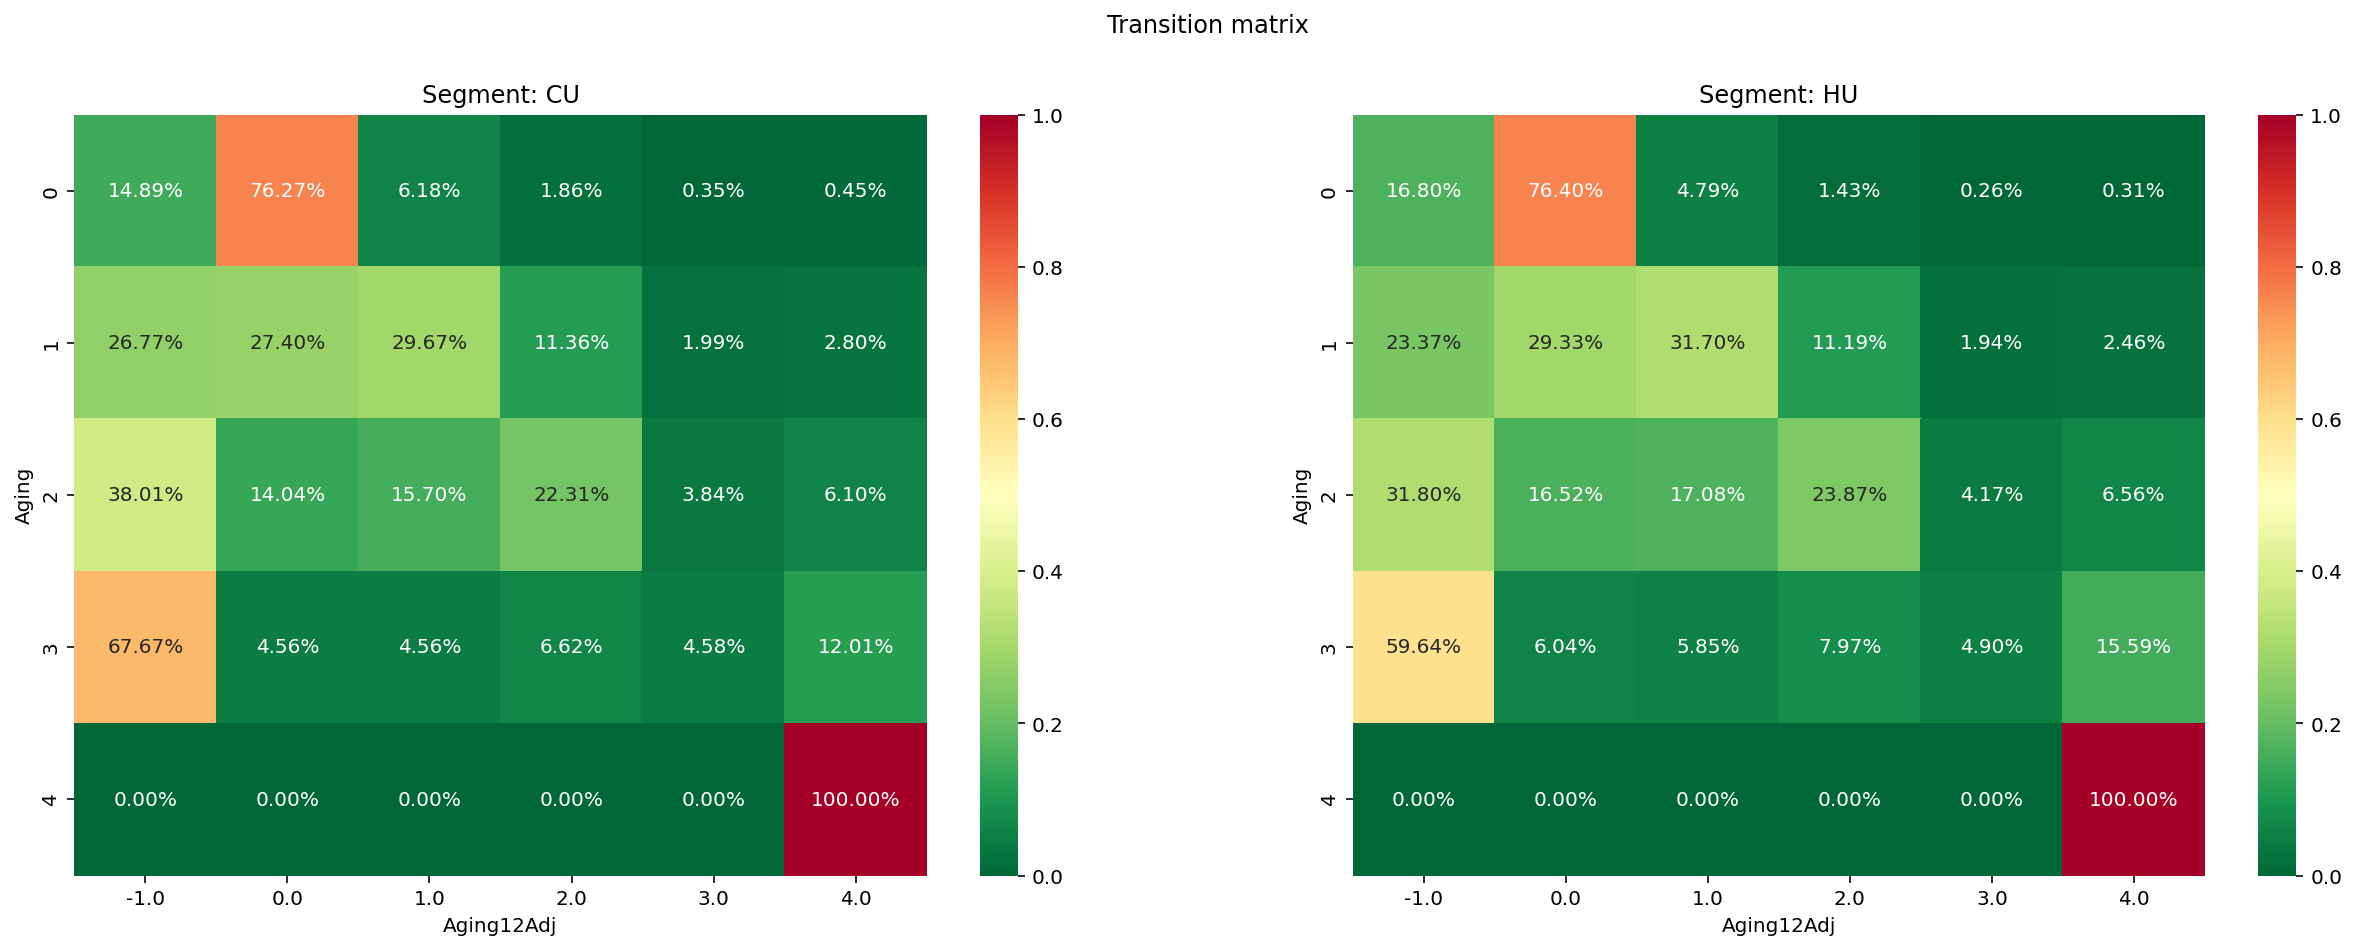

In [17]:
# Plot
plotMatrix(matrix)

In [18]:
# Transition matrix adjustment
# Adjust closed out from the matrix
# Adj DF = DF / (1 - closed)
matrixAdj = matrix.div(1 - matrix[-1], axis = 0).drop([-1], axis = 1) #Drop closed rate
matrixAdj

Aging12Adj          0.0       1.0       2.0       3.0       4.0
Segment Aging                                                  
CU      0      0.896149  0.072655  0.021812  0.004086  0.005299
        1      0.374154  0.405160  0.155166  0.027233  0.038288
        2      0.226431  0.253265  0.359929  0.061955  0.098421
        3      0.141107  0.141107  0.204689  0.141529  0.371567
        4      0.000000  0.000000  0.000000  0.000000  1.000000
HU      0      0.918314  0.057591  0.017241  0.003153  0.003702
        1      0.382783  0.413702  0.146049  0.025322  0.032144
        2      0.242161  0.250490  0.350020  0.061146  0.096183
        3      0.149656  0.145042  0.197572  0.121489  0.386240
        4      0.000000  0.000000  0.000000  0.000000  1.000000

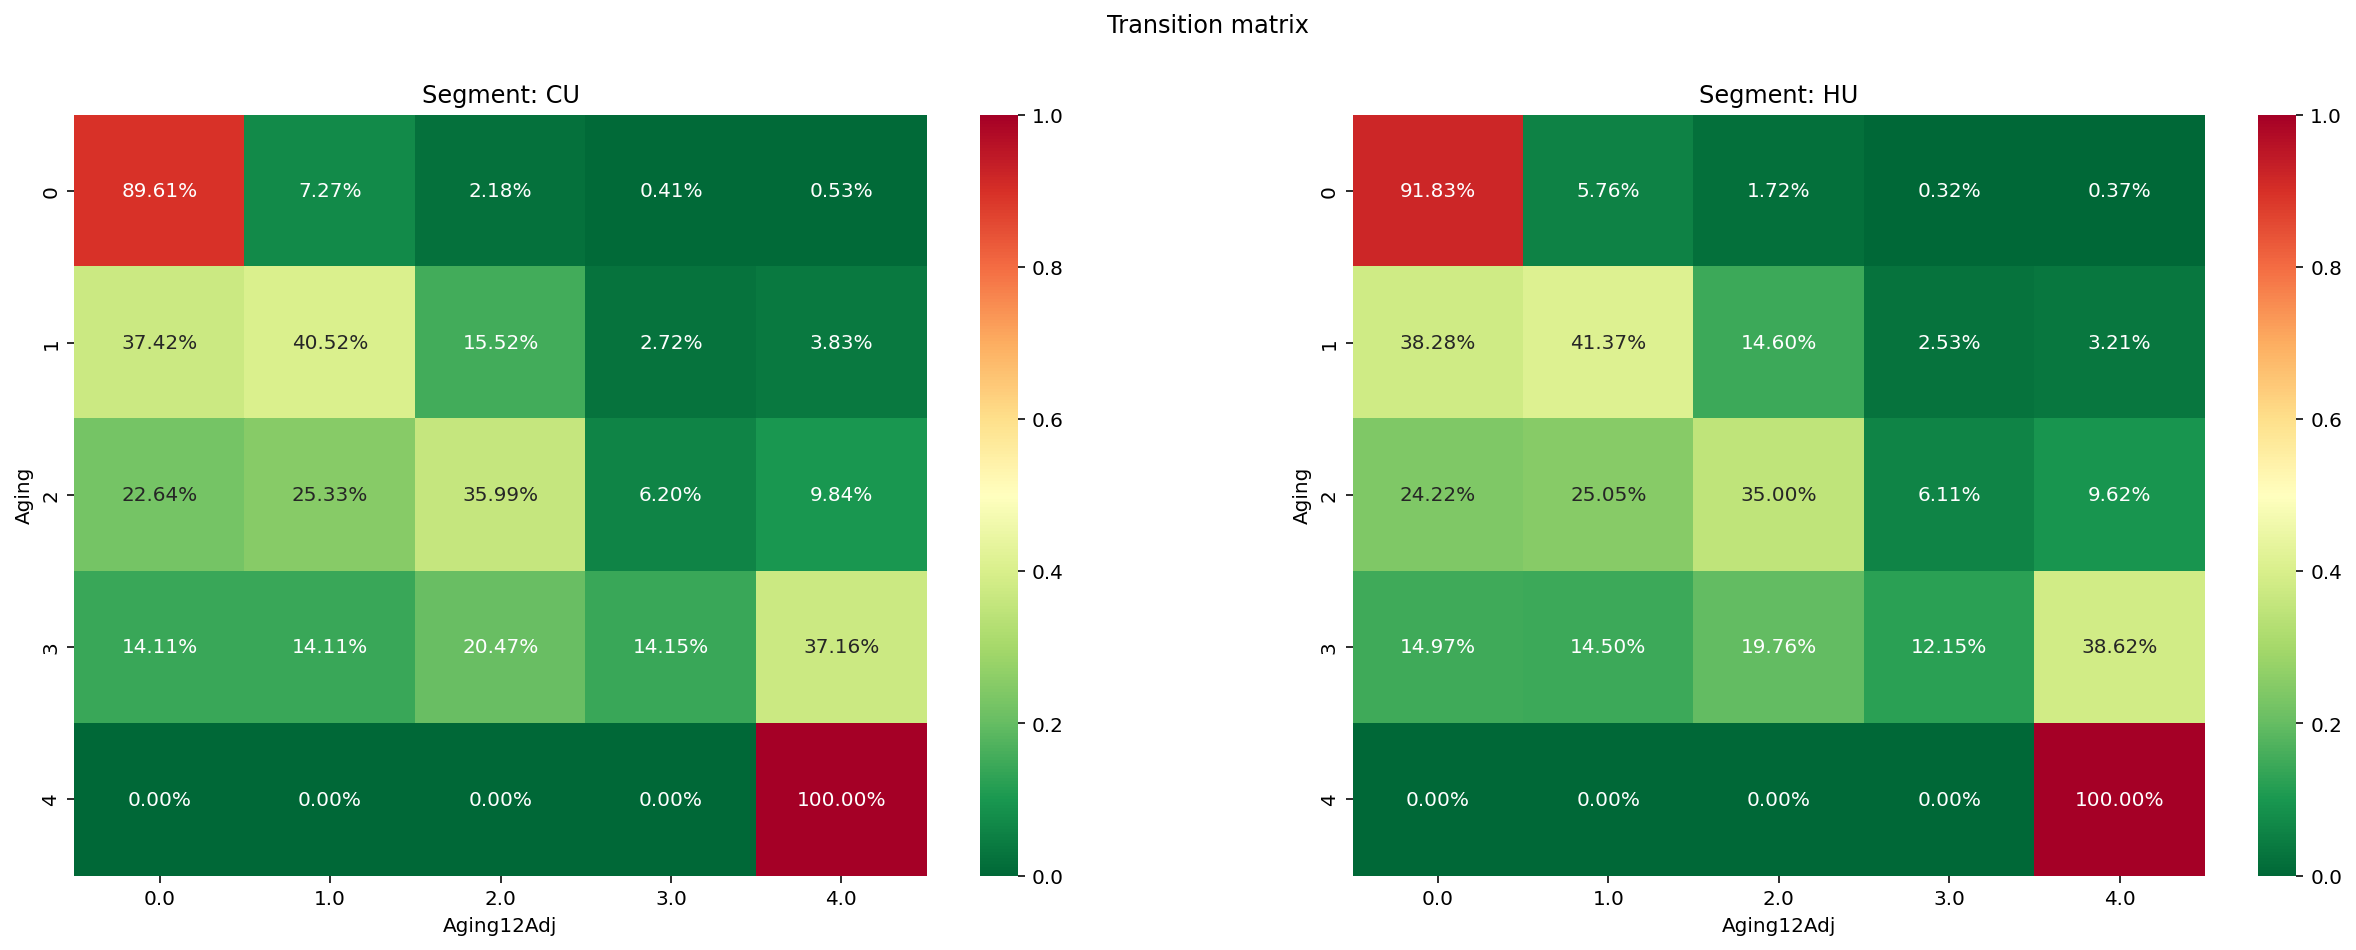

In [19]:
# Plot
plotMatrix(matrixAdj)

In [20]:
# Matrix multiplication for lifetime
years = 10 #Create lifetime PD for 10-years
lifetimeResults = None

for segment in matrixAdj.index.get_level_values(0).unique():
  lifetime = matrixAdj.loc[segment].to_numpy() #Select segment and convert to array
  baseMatrix = lifetime.copy()
  lifetimePD = lifetime[:, -1][:-1] #Keep first year PD
  for i in range(years):
    if i == 0:
      pass
    else:
      lifetimeCum = np.dot(baseMatrix, lifetime[-5:, :])
      lifetime = np.vstack((lifetime, lifetimeCum)) #Keep cumulative matrix
      lifetimePD = np.vstack((lifetimePD, lifetimeCum[:, -1][:-1])) #Keep only default bucket
      lifetimeResult = pd.DataFrame(lifetimePD, columns = range(lifetimePD.shape[1])) #Format to DataFrame
      lifetimeResult['Segment']  = segment
  if lifetimeResults is None:
    lifetimeResults = lifetimeResult.copy()
  else:
    lifetimeResults = pd.concat([lifetimeResults, lifetimeResult], axis = 0, ignore_index = False) #Keep index

# Create times
lifetimeResults['times'] = lifetimeResults.index + 1

In [21]:
# Format long table
lifetimeResults = pd.melt(lifetimeResults,
                          id_vars = ['Segment', 'times'],
                          var_name = 'Aging', value_name = 'PD')

lifetimeResults.to_csv('lifetimeMatrix.csv', index = 0) #Export result
lifetimeResults.head(5)

,Segment,times,Aging,PD
0,CU,1,0,0.005299
1,CU,2,0,0.016494
2,CU,3,0,0.031477
3,CU,4,0,0.048487
4,CU,5,0,0.066437


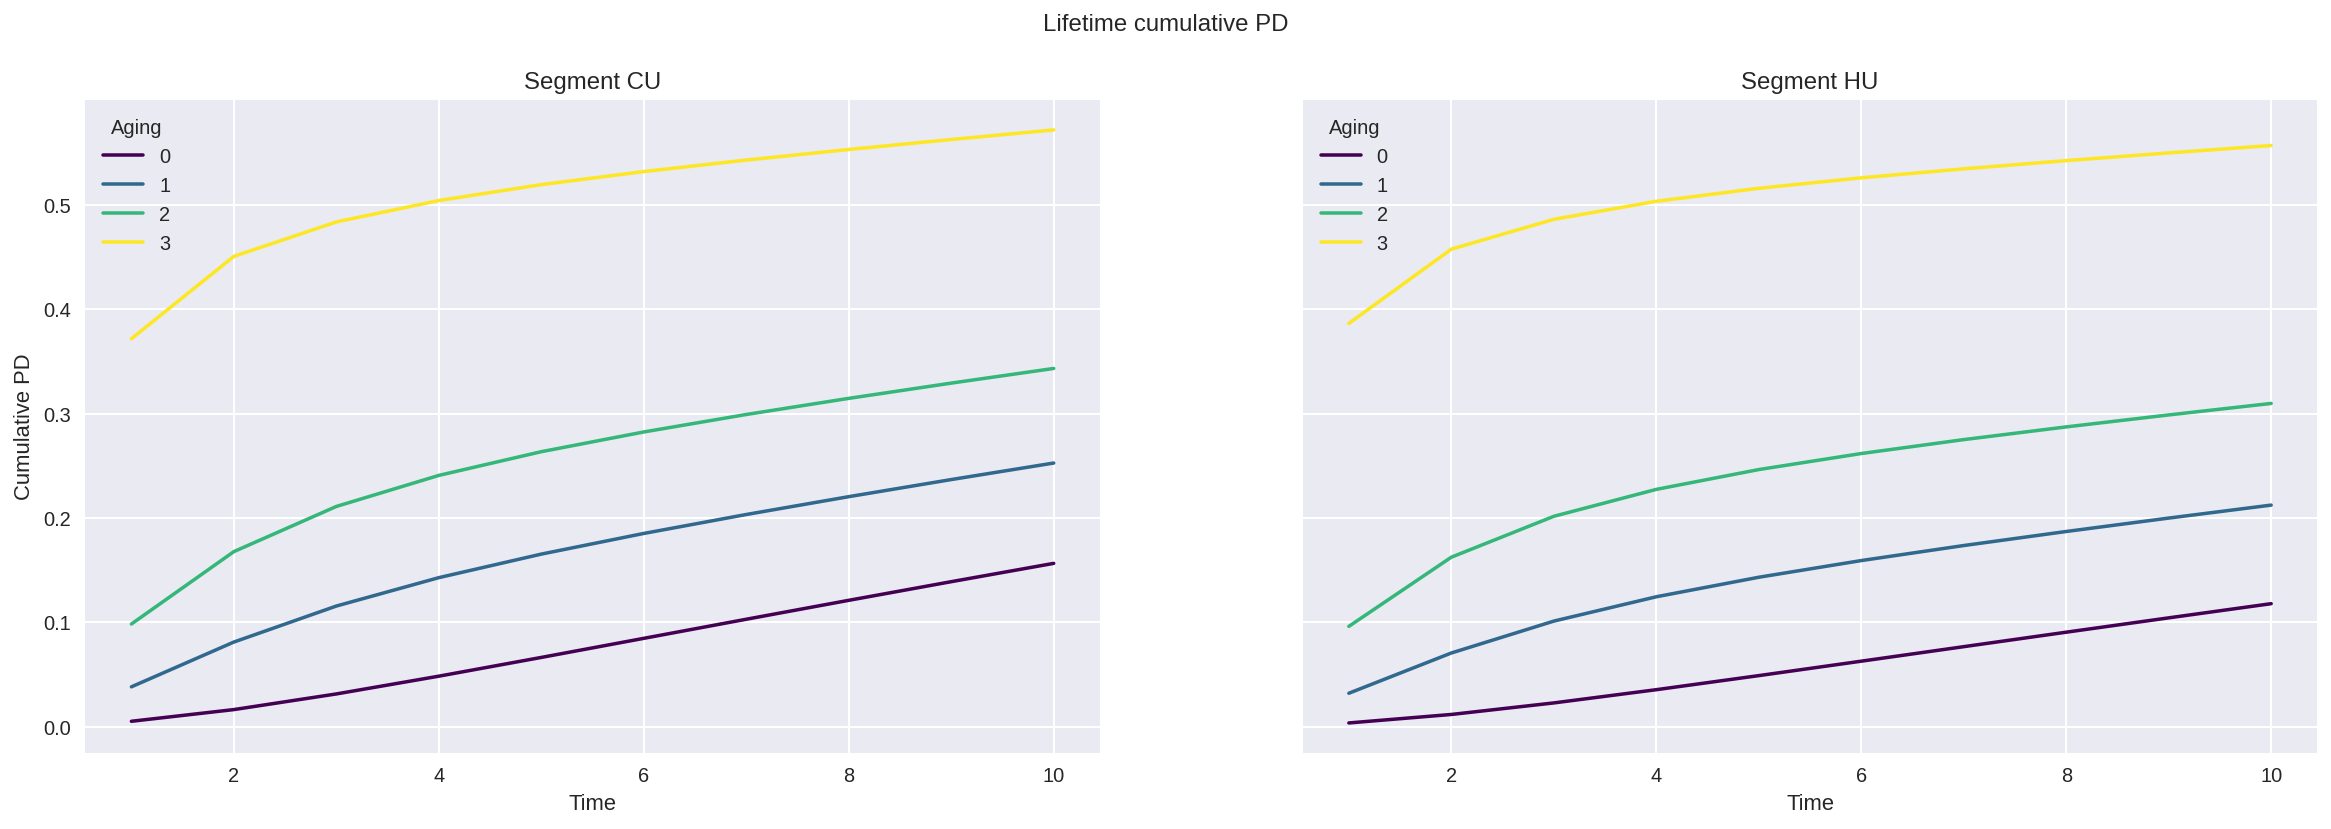

In [22]:
# Plot
with plt.style.context('seaborn'):
  fig, axs = plt.subplots(1, 2, figsize = (20, 6), sharey = True)
  fig.suptitle('Lifetime cumulative PD')
  for i, segment in enumerate(lifetimeResults['Segment'].unique()):
    selectData = lifetimeResults.query('Segment == @segment')
    sns.lineplot(x = 'times', y = 'PD', data = selectData,
                 hue = 'Aging', legend = 'full',
                 palette = 'viridis', ci = None, ax = axs[i])
    axs[i].set_title(f'Segment {segment}')
    axs[i].set(xlabel = 'Time', ylabel = 'Cumulative PD')
  plt.show()